### TPC Benchmarking  
Results Plotting  

In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 1.0})

In [44]:
fpb = "/home/colin/data/tpc_logs/"

In [45]:
fps = ["bq_h_query_times-100GB-h_100GB_01-default-2020-05-01 09:54:14.099669.csv",
       "bq_h_query_times-100GB-h_100GB_02-part & cluster A-2020-05-01 10:31:11.485879.csv"]

In [46]:
# type of test being plotted, choose one.
x_type = "query_n"
#x_type = "stream_p"

In [5]:
def parse(fp, x_type):
    x_type = {"q":"query_n", "s":"stream_p"}[x_type]
    df = pd.read_csv(fp)
    df.t0 = pd.to_datetime(df.t0)
    df.t1 = pd.to_datetime(df.t1)
    df["dt"] = df.t1 - df.t0
    df["dt_s"] = df.dt.dt.total_seconds()
    return df

In [6]:
df = pd.DataFrame(None)

In [7]:
for _fp in fps:
    _df = parse(fpb + _fp, "q")
    df = pd.concat([df, _df])

In [162]:
df["description"] = df.desc

#### QUERY/STREAM PLOTS

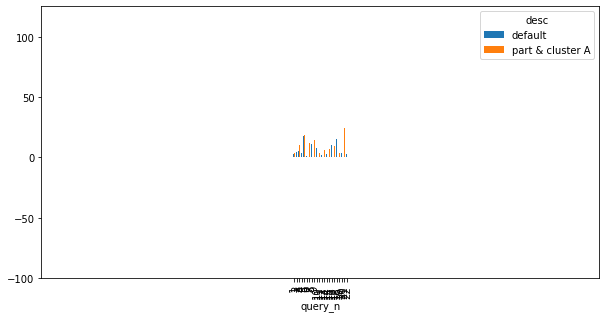

In [8]:
ax = df.pivot(index="query_n", columns="desc", values="dt_s").plot.bar(figsize=(10,5));
plot_margin = 100

x0, x1, y0, y1 = plt.axis()
plt.axis((x0 - plot_margin,
          x1 + plot_margin,
          y0 - plot_margin,
          y1 + plot_margin))
plt.show()

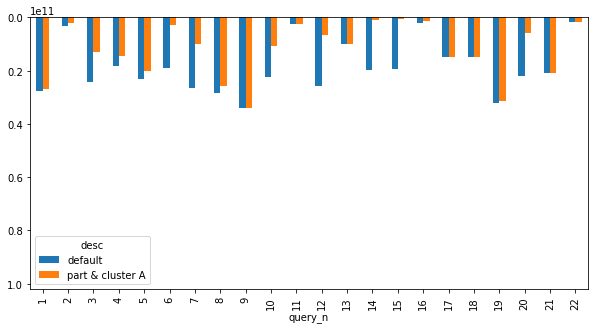

In [9]:
ax = df.pivot(index="query_n", columns="desc", values="bytes_processed").plot.bar(figsize=(10,5));
ax.invert_yaxis();
ax.margins(2)

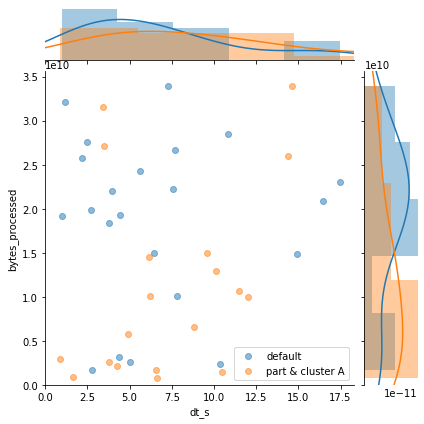

In [34]:
multivariateGrid(col_x="dt_s", col_y="bytes_processed", col_k="desc", df=df)

In [35]:
def multivariateGrid(col_x, col_y, col_k, df, k_is_color=False, scatter_alpha=.5):
    def colored_scatter(x, y, c=None):
        def scatter(*args, **kwargs):
            args = (x, y)
            if c is not None:
                kwargs['c'] = c
            kwargs['alpha'] = scatter_alpha
            plt.scatter(*args, **kwargs)
            plt.xlim(left=0)
            plt.ylim(bottom=0)

        return scatter

    g = sns.JointGrid(
        x=col_x,
        y=col_y,
        data=df
    )
    color = None
    legends=[]
    for name, df_group in df.groupby(col_k):
        legends.append(name)
        if k_is_color:
            color=name
        g.plot_joint(
            colored_scatter(df_group[col_x],df_group[col_y],color),
        )
        #sns.distplot(
        #    df_group[col_x].values,
        #    ax=g.ax_marg_x,
        #    color=color,
        #)
        sns.distplot(
            df_group[col_y].values,
            ax=g.ax_marg_y,
            color=color,            
            vertical=True
        )
    # Do also global Hist:
    """
    sns.distplot(
        df[col_x].values,
        ax=g.ax_marg_x,
        color='grey'
    )
    sns.distplot(
        df[col_y].values.ravel(),
        ax=g.ax_marg_y,
        color='grey',
        vertical=True
    )
    """
    plt.legend(legends)

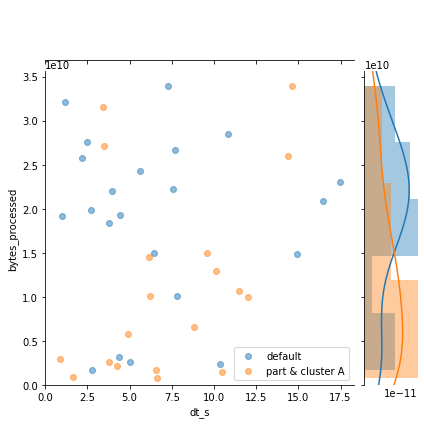

In [36]:
multivariateGrid(col_x="dt_s", col_y="bytes_processed", col_k="desc", df=df)

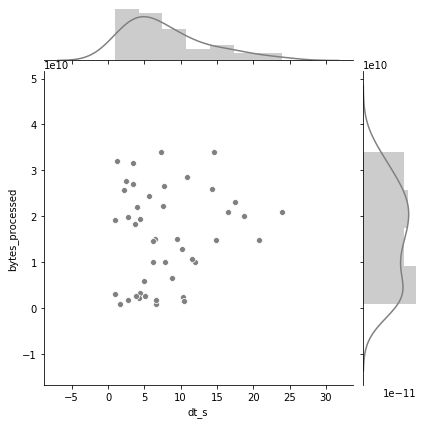

In [54]:
g = sns.JointGrid(x="dt_s", y="bytes_processed", data=df)
g = g.plot_joint(sns.scatterplot, color=".5")
g = g.plot_marginals(sns.distplot, kde=True, color=".5") #, bins=np.arange(0,22,1))

In [70]:
dfp_dt = df.pivot(index="query_n", columns="desc", values="dt_s")  #.plot.bar(figsize=(10,5));
dfp_bp = df.pivot(index="query_n", columns="desc", values="bytes_processed")  #.plot.bar(figsize=(10,5));

In [71]:
def bytes_to_TebiByte(b):
    return b / 1099511627776

In [72]:
dfp_bp = dfp_bp.apply(bytes_to_TebiByte)

In [153]:
sns.set_style({"xtick.bottom":True})

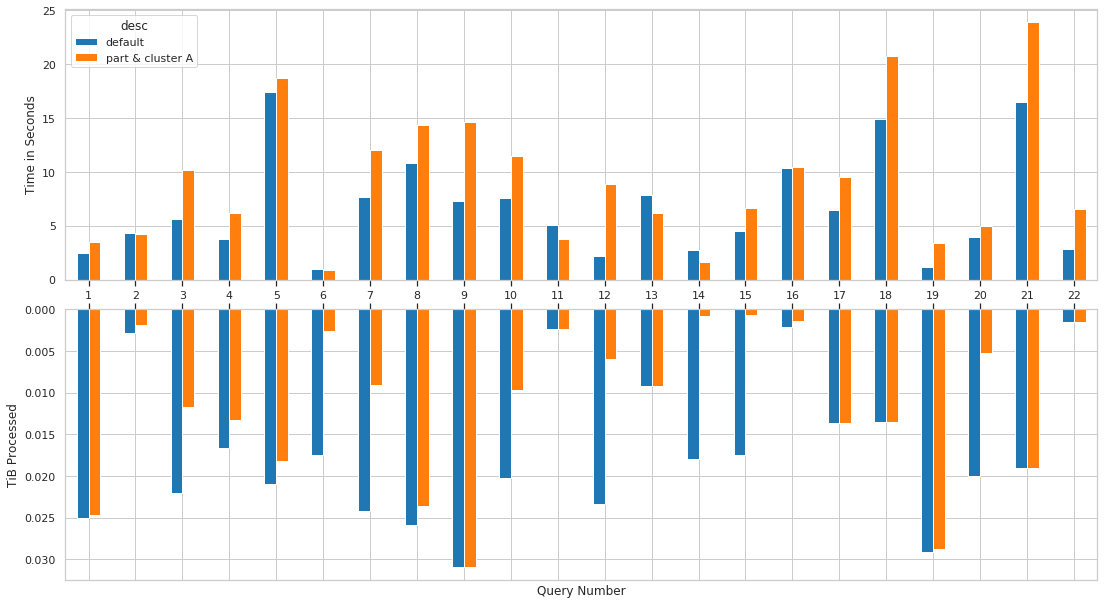

In [158]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1 = dfp_dt.plot.bar(ax=ax1, legend=True)
ax2 = dfp_bp.plot.bar(ax=ax2, legend=False);

# set the figure size BEFORE adjusting ticks
fig.set_size_inches(18.5, 10.5)

ax1.set_ylabel("Time in Seconds")
ax1.set_xlabel(None)
ax1_xticklabels = ax1.get_xticklabels()
ax1.set_xticklabels(labels=[]) #, rotation=0)

ax2.set_ylabel("TiB Processed")
ax2.set_xlabel("Query Number")
ticks =  ax2.get_yticks()
ticks = ["{:01.3f}".format(abs(tick)) for tick in ticks]
ax2.set_yticklabels(ticks);
ax2.xaxis.tick_top()

plt.subplots_adjust(hspace=0.11)
print();